In [9]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp

def knee_extension():
    print('Knee extension')

    def ode(t, x):
        gx1 = gm_interp(x[0])
        dx1dt = x[1]
        gx1_eps = gx1 if gx1 > 1e-12 else 1e-12  # Avoid division by zero
        dx2dt = -gi + (gx1_eps / m) * (c / (gx1_eps * x[1] + b) - a) * (1 - np.exp(-S * (t - tau)))

        value = [vmax - x[1] * gm_interp(x[0]), lt + ls - x[0]]

        if value[0] <= 0 or value[1] <= 0:
            # Terminate integration when either condition is met
            dx1dt = 0
            dx2dt = 0

        return np.array([dx1dt, dx2dt])

    def GX(lt, ls, kt, ks, r):
        bet = np.arange(0, np.pi / 2, 0.01)
        sigma = 2 * bet + np.arcsin((r / kt) * np.sin(bet)) + np.arcsin((r / ks) * np.sin(bet))
        sigma = sigma[sigma < np.pi]
        beta = bet[:len(sigma)]
        X = np.sqrt(lt ** 2 + ls ** 2 - 2 * lt * ls * np.cos(sigma))
        G = np.zeros_like(X)
        non_zero_denom = (lt * ls * np.sin(sigma)) > 1e-12
        G[non_zero_denom] = ((r * np.sin(beta[non_zero_denom])) / (lt * ls * np.sin(sigma[non_zero_denom]))) * X[non_zero_denom]
        return np.column_stack((X, G))

    lt = 0.52
    ls = 0.45
    kt = 0.52
    ks = 0.06
    r = 0.06
    a = 5000
    b = 0.1
    c = 4186
    S = 7
    m = 95
    alpha = 90
    g = 9.81
    X0 = 0.65
    V0 = 0
    t0 = 0
    te = 3

    gm = GX(lt, ls, kt, ks, r)
    gm_interp = interp1d(gm[:, 0], gm[:, 1], kind='cubic', bounds_error=False, fill_value="extrapolate")
    vmax = c / a - b
    gi = np.sin(alpha * np.pi / 180) * g
    GX0 = gm_interp(X0)

    if GX0 * V0 > vmax:
        raise ValueError('Muscle contraction velocity is greater than vmax')

    if m * gi > GX0 * (c / (GX0 * V0 + b) - a):
        raise ValueError('Eccentric movement')

    A0 = m * gi / (GX0 * (c / (GX0 * V0 + b) - a))

    if A0 < 1:
        tau = 1 / S * np.log(1 - A0)
    else:
        tau = -1000

    t_eval = np.linspace(t0, te, 1000)

    sol = solve_ivp(ode, [t0, te], [X0, V0], t_eval=t_eval, rtol=1e-6, max_step=0.001)

    t_vals = sol.t
    X_vals = sol.y[0]
    V_vals = sol.y[1]

    G_vals = gm_interp(X_vals)
    v_vals = G_vals * V_vals
    f_vals = (c / (v_vals + b) - a) * (1 - np.exp(-S * (t_vals - tau)))
    F_vals = G_vals * f_vals

    print('\nXend    [m]    =', X_vals[-1])
    print('Vmax    [m/s]  =', np.max(V_vals))
    print('Vend    [m/s]  =', V_vals[-1])
    print('tend    [s]    =', t_vals[-1])
    print('tau     [s]    =', tau)
    print('int Fdt [Ns]   =', np.trapz(F_vals, t_vals))
    print('Fmax    [N]    =', np.max(F_vals))
    print('int Pdt [J]    =', np.trapz(F_vals * V_vals, t_vals))
    print('Pmax    [W]    =', np.max(F_vals * V_vals))

knee_extension()


Knee extension

Xend    [m]    = 0.9548751404169241
Vmax    [m/s]  = 1.4307085357226805
Vend    [m/s]  = 1.33694671280966
tend    [s]    = 3.0
tau     [s]    = -0.057827984468946776
int Fdt [Ns]   = 475.89259885480635
Fmax    [N]    = 1449.60146947887
int Pdt [J]    = 361.89788060594464
Pmax    [W]    = 1640.243162866069


In [10]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp

def knee_extension():
    """
    Simulate knee extension movement using an ODE solver.

    Returns:
    None
        Prints out relevant results and information.
    """

    # Define the ODE function for knee extension
    def ode(t, x):
        """
        ODE function for knee extension movement.

        Parameters:
        t (float): Current time [s]
        x (ndarray): State variables [position, velocity]

        Returns:
        ndarray: Derivatives of state variables [velocity, acceleration]
        """
        gx1 = gm_interp(x[0])
        dx1dt = x[1]
        gx1_eps = gx1 if gx1 > 1e-12 else 1e-12  # Avoid division by zero
        dx2dt = -gi + (gx1_eps / m) * (c / (gx1_eps * x[1] + b) - a) * (1 - np.exp(-S * (t - tau)))

        value = [vmax - x[1] * gm_interp(x[0]), lt + ls - x[0]]

        if value[0] <= 0 or value[1] <= 0:
            # Terminate integration when either condition is met
            dx1dt = 0
            dx2dt = 0

        return np.array([dx1dt, dx2dt])

    # Function to calculate muscle-tendon length relationship
    def GX(lt, ls, kt, ks, r):
        """
        Calculate muscle-tendon length relationship.

        Parameters:
        lt (float): Length of thigh [m]
        ls (float): Length of shank [m]
        kt (float): Thigh center to knee joint distance [m]
        ks (float): Shank center to knee joint distance [m]
        r (float): Shank radius [m]

        Returns:
        ndarray: Muscle-tendon length and corresponding force values.
        """
        bet = np.arange(0, np.pi / 2, 0.01)
        sigma = 2 * bet + np.arcsin((r / kt) * np.sin(bet)) + np.arcsin((r / ks) * np.sin(bet))
        sigma = sigma[sigma < np.pi]
        beta = bet[:len(sigma)]
        X = np.sqrt(lt ** 2 + ls ** 2 - 2 * lt * ls * np.cos(sigma))
        G = np.zeros_like(X)
        non_zero_denom = (lt * ls * np.sin(sigma)) > 1e-12
        G[non_zero_denom] = ((r * np.sin(beta[non_zero_denom])) / (lt * ls * np.sin(sigma[non_zero_denom]))) * X[non_zero_denom]
        return np.column_stack((X, G))

    # Parameters
    lt = 0.52   # Length of thigh [m]
    ls = 0.45   # Length of shank [m]
    kt = 0.52   # Thigh center to knee joint distance [m]
    ks = 0.06   # Shank center to knee joint distance [m]
    r = 0.06    # Shank radius [m]
    a = 5000    # Coefficient of muscle tension-length relationship [N]
    b = 0.1     # Coefficient of muscle tension-velocity relationship [Ns/m]
    c = 4186    # Coefficient of muscle force-velocity relationship [N]
    S = 7       # Muscle contraction dynamics [1/s]
    m = 95      # Subject mass [kg]
    alpha = 90  # Angle of muscle orientation [degrees]
    g = 9.81    # Acceleration due to gravity [m/s^2]

    # Initial conditions
    X0 = 0.65   # Initial position [m]
    V0 = 0      # Initial velocity [m/s]
    t0 = 0      # Initial time [s]
    te = 3      # End time [s]

    # Calculate muscle-tendon length relationship
    gm = GX(lt, ls, kt, ks, r)
    gm_interp = interp1d(gm[:, 0], gm[:, 1], kind='cubic', bounds_error=False, fill_value="extrapolate")

    # Maximum contraction velocity
    vmax = c / a - b

    # Effective acceleration due to muscle contraction
    gi = np.sin(alpha * np.pi / 180) * g

    # Calculate initial muscle length relationship
    GX0 = gm_interp(X0)

    # Check for muscle contraction velocity exceeding vmax
    if GX0 * V0 > vmax:
        raise ValueError('Muscle contraction velocity is greater than vmax')

    # Check for eccentric movement
    if m * gi > GX0 * (c / (GX0 * V0 + b) - a):
        raise ValueError('Eccentric movement')

    # Calculate initial muscle activation level
    A0 = m * gi / (GX0 * (c / (GX0 * V0 + b) - a))

    # Calculate muscle activation delay (tau)
    if A0 < 1:
        tau = 1 / S * np.log(1 - A0)
    else:
        tau = -1000

    # Time evaluation points
    t_eval = np.linspace(t0, te, 1000)

    # Solve the ODE using the solve_ivp function
    sol = solve_ivp(ode, [t0, te], [X0, V0], t_eval=t_eval, rtol=1e-6, max_step=0.001)

    # Extract results from the solution
    t_vals = sol.t
    X_vals = sol.y[0]
    V_vals = sol.y[1]

    # Calculate muscle-tendon length, muscle force, and muscle velocity
    G_vals = gm_interp(X_vals)
    v_vals = G_vals * V_vals
    f_vals = (c / (v_vals + b) - a) * (1 - np.exp(-S * (t_vals - tau)))
    F_vals = G_vals * f_vals

    # Print results
    print('\nXend    [m]    =', X_vals[-1])
    print('Vmax    [m/s]  =', np.max(V_vals))
    print('Vend    [m/s]  =', V_vals[-1])
    print('tend    [s]    =', t_vals[-1])
    print('tau     [s]    =', tau)
    print('int Fdt [Ns]   =', np.trapz(F_vals, t_vals))
    print('Fmax    [N]    =', np.max(F_vals))
    print('int Pdt [J]    =', np.trapz(F_vals * V_vals, t_vals))
    print('Pmax    [W]    =', np.max(F_vals * V_vals))

# Call the main function
knee_extension()



Xend    [m]    = 0.9548751404169241
Vmax    [m/s]  = 1.4307085357226805
Vend    [m/s]  = 1.33694671280966
tend    [s]    = 3.0
tau     [s]    = -0.057827984468946776
int Fdt [Ns]   = 475.89259885480635
Fmax    [N]    = 1449.60146947887
int Pdt [J]    = 361.89788060594464
Pmax    [W]    = 1640.243162866069



Xend    [m]    = 0.9548437446332688
Vmax    [m/s]  = 1.4307098095808148
Vend    [m/s]  = 1.3371771771705445
tend    [s]    = 0.38007
tau     [s]    = -0.057827984468946776
int Fdt [Ns]   = 481.2367769898498
Fmax    [N]    = 1449.6026112892073
int Pdt [J]    = 369.0296450257541
Pmax    [W]    = 1640.3276856845532


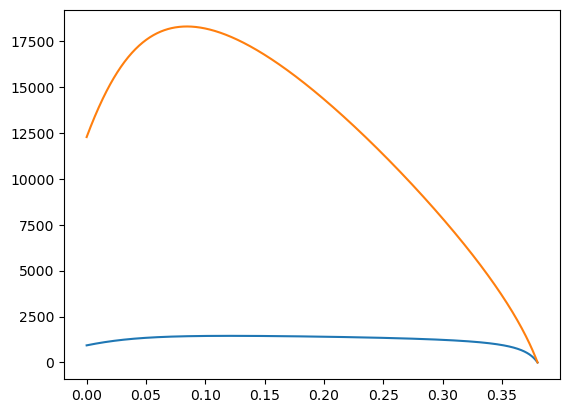

In [21]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
def knee_extension(lt=0.52, ls=0.45, kt=0.52, ks=0.06, r=0.06, a=5000, b=0.1, c=4186, S=7, m=95, alpha=90, g=9.81, X0=0.65, V0=0, t0=0, te=0.38007):
    """
    Simulate knee extension movement using an ODE solver.

    Parameters:
    lt (float): Length of thigh [m]
    ls (float): Length of shank [m]
    kt (float): Thigh center to knee joint distance [m]
    ks (float): Shank center to knee joint distance [m]
    r (float): Shank radius [m]
    a (float): Coefficient of muscle tension-length relationship [N]
    b (float): Coefficient of muscle tension-velocity relationship [Ns/m]
    c (float): Coefficient of muscle force-velocity relationship [N]
    S (float): Muscle contraction dynamics [1/s]
    m (float): Subject mass [kg]
    alpha (float): Angle of muscle orientation [degrees]
    g (float): gravity [m/s**2]
    X0 (float): Initial position [m]
    V0 (float): Initial velocity [m/s]
    t0 (float): Initial time [s]
    te (float): End time [s]

    Returns:
    None
        Prints out relevant results and information.
    """

    # Define the ODE function for knee extension
    def ode(t, x):
        """
        ODE function for knee extension movement.

        Parameters:
        t (float): Current time [s]
        x (ndarray): State variables [position, velocity]

        Returns:
        ndarray: Derivatives of state variables [velocity, acceleration]
        """
        gx1 = gm_interp(x[0])
        dx1dt = x[1]
        gx1_eps = gx1 if gx1 > 1e-12 else 1e-12  # Avoid division by zero
        dx2dt = -gi + (gx1_eps / m) * (c / (gx1_eps * x[1] + b) - a) * (1 - np.exp(-S * (t - tau)))

        value = [vmax - x[1] * gm_interp(x[0]), lt + ls - x[0]]

        if value[0] <= 0 or value[1] <= 0:
            # Terminate integration when either condition is met
            dx1dt = 0
            dx2dt = 0

        return np.array([dx1dt, dx2dt])

    # Function to calculate muscle-tendon length relationship
    def GX(lt, ls, kt, ks, r):
        """
        Calculate muscle-tendon length relationship.

        Parameters:
        lt (float): Length of thigh [m]
        ls (float): Length of shank [m]
        kt (float): Thigh center to knee joint distance [m]
        ks (float): Shank center to knee joint distance [m]
        r (float): Shank radius [m]

        Returns:
        ndarray: Muscle-tendon length and corresponding force values.
        """
        bet = np.arange(0, np.pi / 2, 0.01)
        sigma = 2 * bet + np.arcsin((r / kt) * np.sin(bet)) + np.arcsin((r / ks) * np.sin(bet))
        sigma = sigma[sigma < np.pi]
        beta = bet[:len(sigma)]
        X = np.sqrt(lt ** 2 + ls ** 2 - 2 * lt * ls * np.cos(sigma))
        G = np.zeros_like(X)
        non_zero_denom = (lt * ls * np.sin(sigma)) > 1e-12
        G[non_zero_denom] = ((r * np.sin(beta[non_zero_denom])) / (lt * ls * np.sin(sigma[non_zero_denom]))) * X[non_zero_denom]
        return np.column_stack((X, G))

    # Calculate muscle-tendon length relationship
    gm = GX(lt, ls, kt, ks, r)
    gm_interp = interp1d(gm[:, 0], gm[:, 1], kind='cubic', bounds_error=False, fill_value="extrapolate")

    # Maximum contraction velocity
    vmax = c / a - b

    # Effective acceleration due to muscle contraction
    gi = np.sin(alpha * np.pi / 180) * g

    # Calculate initial muscle length relationship
    GX0 = gm_interp(X0)

    # Check for muscle contraction velocity exceeding vmax
    if GX0 * V0 > vmax:
        raise ValueError('Muscle contraction velocity is greater than vmax')

    # Check for eccentric movement
    if m * gi > GX0 * (c / (GX0 * V0 + b) - a):
        raise ValueError('Eccentric movement')

    # Calculate initial muscle activation level
    A0 = m * gi / (GX0 * (c / (GX0 * V0 + b) - a))

    # Calculate muscle activation delay (tau)
    if A0 < 1:
        tau = 1 / S * np.log(1 - A0)
    else:
        tau = -1000

    # Time evaluation points
    t_eval = np.linspace(t0, te, 1000)

    # Solve the ODE using the solve_ivp function
    sol = solve_ivp(ode, [t0, te], [X0, V0], t_eval=t_eval, rtol=1e-6, max_step=0.001)

    # Extract results from the solution
    t_vals = sol.t
    X_vals = sol.y[0]
    V_vals = sol.y[1]

    # Calculate muscle-tendon length, muscle force, and muscle velocity
    G_vals = gm_interp(X_vals)
    v_vals = G_vals * V_vals
    f_vals = (c / (v_vals + b) - a) * (1 - np.exp(-S * (t_vals - tau)))
    F_vals = G_vals * f_vals

    # Print results
    print('\nXend    [m]    =', X_vals[-1])
    print('Vmax    [m/s]  =', np.max(V_vals))
    print('Vend    [m/s]  =', V_vals[-1])
    print('tend    [s]    =', t_vals[-1])
    print('tau     [s]    =', tau)
    print('int Fdt [Ns]   =', np.trapz(F_vals, t_vals))
    print('Fmax    [N]    =', np.max(F_vals))
    print('int Pdt [J]    =', np.trapz(F_vals * V_vals, t_vals))
    print('Pmax    [W]    =', np.max(F_vals * V_vals))
    return(t_vals,F_vals,f_vals)
# Call the main function
t, F, f = knee_extension()
plt.plot(t,F)
plt.plot(t,f)
plt.show()